In [30]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data, load_pt_results)
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
behavior = load_behavioral_data(min_RT = 0.2)
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]
data["loss_over_gain"] = np.log(data["loss"] / data["gain"])
data["uncertain"] = data["response_int"].apply(lambda x: 1 if x == 2 or x == 3 else 0)

In [4]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)
library(dplyr)
library(broom.mixed)

Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.
Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step


Attaching package: ‘dplyr’

The following object is masked from ‘package:nlme’:

    collapse

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [52]:
%%R -o residual_pupil
# loop through timebins
residual_pupil <- data.frame()
# Create a copy of data with sub, loss_over_gain, gain, loss, condition

for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ poly(loss_over_gain, 2)*condition + RT*condition + blink*condition + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_over_gain | sub), data=data[data$timebin == tb, ])

    # Gather results
    residuals <- residuals(model)
    results <- data.frame(pupil_residual = residuals, 
                        timebin = tb, 
                        trial = data[data$timebin == tb, "trial"],
                        sub = data[data$timebin == tb, "sub"], 
                        loss_over_gain = data[data$timebin == tb, "loss_over_gain"], 
                        gain = data[data$timebin == tb, "gain"], 
                        loss = data[data$timebin == tb, "loss"], 
                        condition = data[data$timebin == tb, "condition"], 
                        RT = data[data$timebin == tb, "RT"],
                        accept = data[data$timebin == tb, "accept"],
                        uncertain = data[data$timebin == tb, "uncertain"])
    residual_pupil <- rbind(residual_pupil, results)
}

boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00658915 (tol = 0.002, component 1)
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00568536 (tol = 0.002, component 1)


In [63]:
pt_results = load_pt_results()
pt_results = pt_results.query("param_name == 'lambda'").reset_index()
# Create 3 quantiles of param_value
pt_results["lambda_quantile"] = pd.qcut(pt_results["param_value"], 2, labels=["Low", "High"])
residual_pupil = residual_pupil.merge(pt_results[["sub", "lambda_quantile"]], on="sub")

In [81]:
# Create 3 quantiles of loss_over_gain
residual_pupil["loss_over_gain_quantile"] = pd.qcut(residual_pupil["loss_over_gain"], 3, labels=["Good", "Okay", "Bad"])

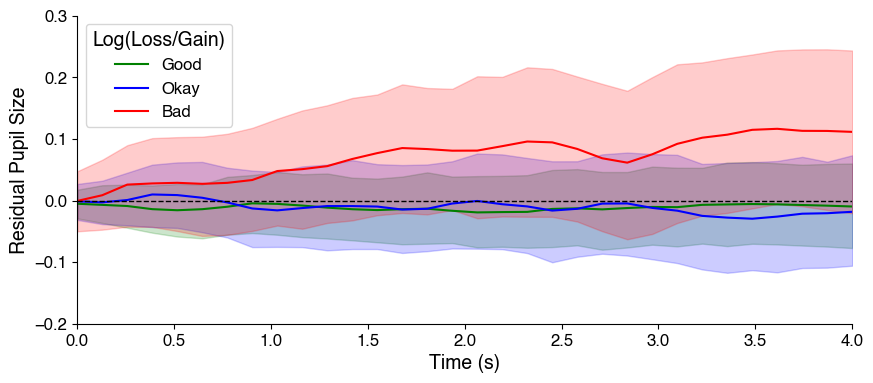

In [84]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Good': 'green', 'Okay': 'blue', "Bad" : 'red'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference' & lambda_quantile == 'Low'"), x="timebin", y="pupil_residual", hue="loss_over_gain_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.3)
# size of legend
plt.legend(title="Log(Loss/Gain)", fontsize=12, title_fontsize=14)
# horizontal line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

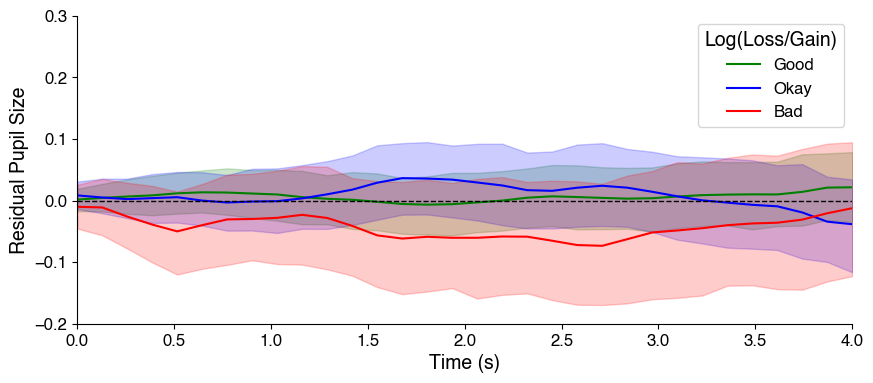

In [85]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Good': 'green', 'Okay': 'blue', "Bad" : 'red'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference' & lambda_quantile == 'High'"), x="timebin", y="pupil_residual", hue="loss_over_gain_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.3)
# size of legend
plt.legend(title="Log(Loss/Gain)", fontsize=12, title_fontsize=14)
# horizontal line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

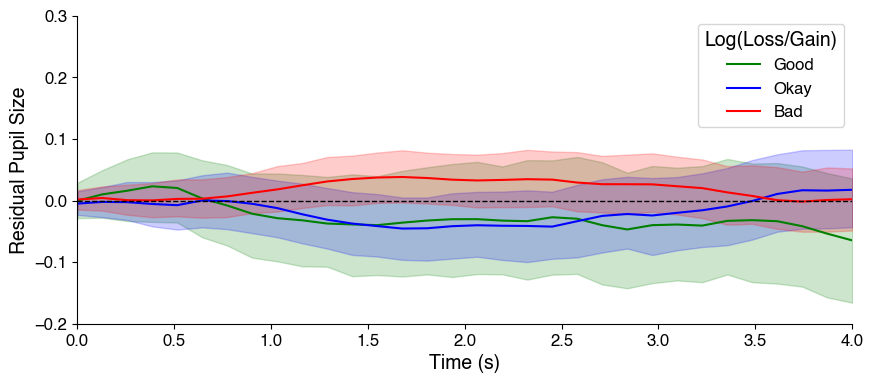

In [86]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Good': 'green', 'Okay': 'blue', "Bad" : 'red'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalRange' & lambda_quantile == 'Low'"), x="timebin", y="pupil_residual", hue="loss_over_gain_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.3)
# size of legend
plt.legend(title="Log(Loss/Gain)", fontsize=12, title_fontsize=14)
# horizontal line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

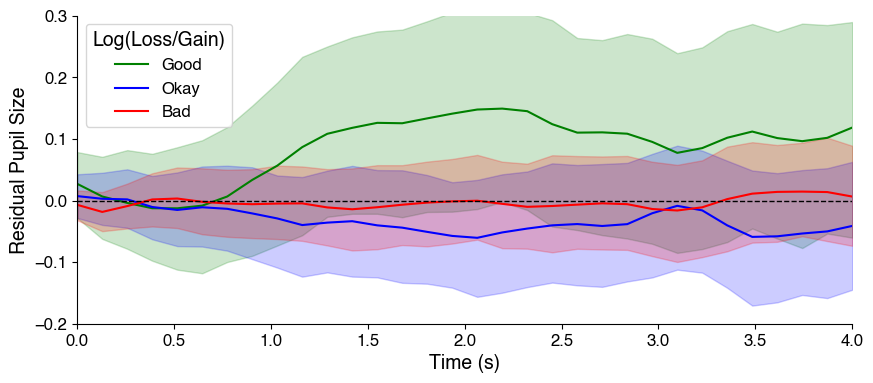

In [87]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Good': 'green', 'Okay': 'blue', "Bad" : 'red'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalRange' & lambda_quantile == 'High'"), x="timebin", y="pupil_residual", hue="loss_over_gain_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.3)
# size of legend
plt.legend(title="Log(Loss/Gain)", fontsize=12, title_fontsize=14)
# horizontal line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

In [54]:
all_subs_effort = []
for sub in behavior["sub"].unique():
    sub_data = behavior.query("sub == @sub")
    response_count = {"accept" : 0, "reject" : 0}
    sub_effort = {"trial" : [], "effort" : [], "sub" : []}
    for trial in sorted(sub_data["trial"].unique()):
        sub_effort["trial"].append(trial)
        sub_effort["sub"].append(sub)

        trial_data = sub_data.query("trial == @trial")
        if trial_data["accept"].values[0] == 1:
            response_count["accept"] += 1
            # I just accepted. If I have been accepting a lot more than rejecting, this is not effortful. 
            if response_count["accept"] > response_count["reject"]:
                sub_effort["effort"].append(0)
            else:
                sub_effort["effort"].append(1)
        else:
            response_count["reject"] += 1
            if response_count["reject"] > response_count["accept"]:
                sub_effort["effort"].append(0)
            else:
                sub_effort["effort"].append(1)
    all_subs_effort.append(pd.DataFrame(sub_effort))
effort = pd.concat(all_subs_effort)

In [56]:
residual_pupil = residual_pupil.merge(effort, on=["sub", "trial"])
pt_results = pt_results.merge(effort.groupby("sub")["effort"].mean(), on="sub")

In [66]:
# if effort is 1, then make it say Effortful; else, make it say Not Effortful
residual_pupil["effort"] = residual_pupil["effort"].apply(lambda x: "Effortful" if x == 1 else "Not Effortful")

In [89]:
pt_results = pt_results.merge(effort.groupby("sub")["effort"].mean(), on="sub")

In [94]:
accept = behavior.groupby("sub")["accept"].mean().reset_index()

In [95]:
pt_results = pt_results.merge(accept, on="sub")

<Axes: xlabel='effort', ylabel='accept'>

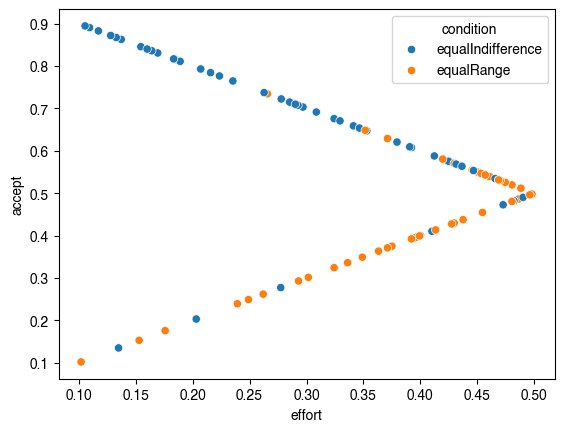

In [97]:
sns.scatterplot(pt_results, x = "effort", y = "accept", hue = "condition")

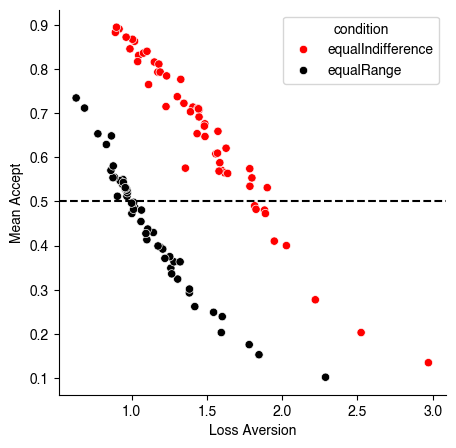

In [99]:
custom_palette = {"equalIndifference": "red", "equalRange": "black"}
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams["font.family"] = "Helvetica"
sns.scatterplot(data=pt_results, x="param_value", y="accept", hue="condition", palette=custom_palette)
plt.xlabel("Loss Aversion")
plt.ylabel("Mean Accept")
# horizontal line at 0.5
plt.axhline(0.5, color="black", linestyle="--")
# Remove the top and right spines
sns.despine()

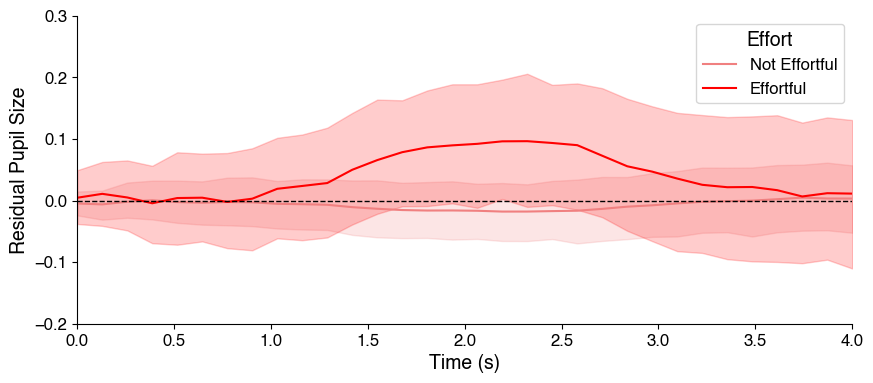

In [77]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Effortful': 'red', 'Not Effortful': 'lightcoral'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference' & lambda_quantile == 'Low'"), x="timebin", y="pupil_residual", hue="effort", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.3)
# size of legend
plt.legend(title="Effort", fontsize=12, title_fontsize=14)
# horizontal line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

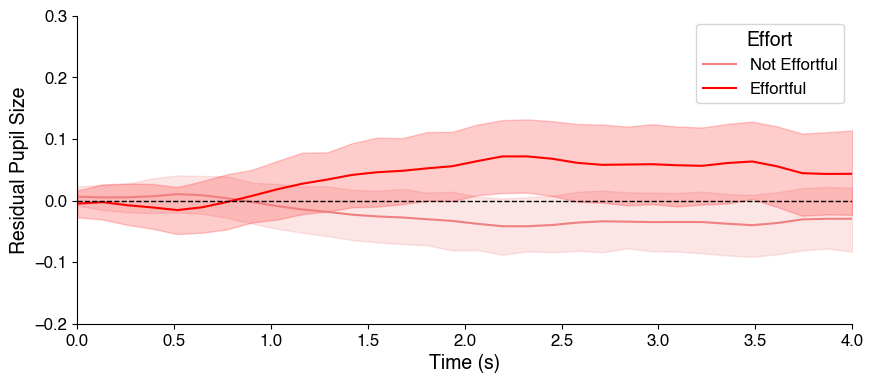

In [76]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Effortful': 'red', 'Not Effortful': 'lightcoral'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference' & lambda_quantile == 'High'"), x="timebin", y="pupil_residual", hue="effort", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.3)
# size of legend
plt.legend(title="Effort", fontsize=12, title_fontsize=14)
# horizontal line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

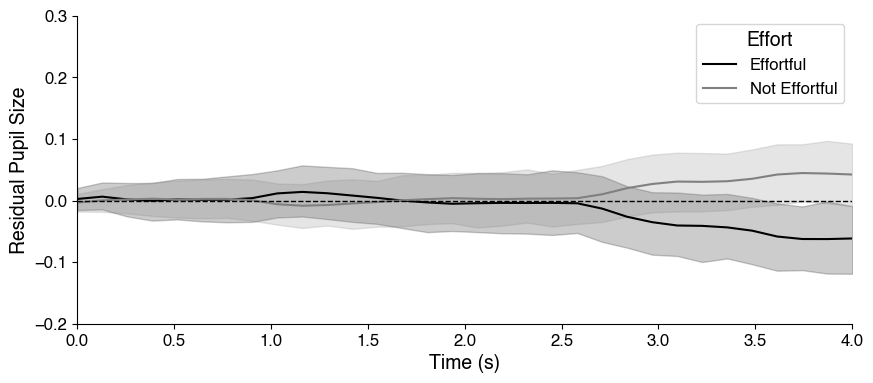

In [78]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Effortful': 'black', 'Not Effortful': 'gray'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalRange' & lambda_quantile == 'Low'"), x="timebin", y="pupil_residual", hue="effort", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.3)
# size of legend
plt.legend(title="Effort", fontsize=12, title_fontsize=14)
# horizontal line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

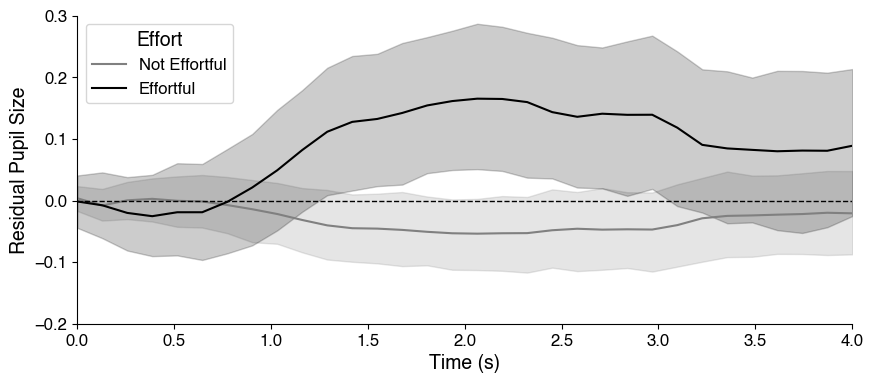

In [74]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Effortful': 'black', 'Not Effortful': 'gray'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalRange' & lambda_quantile == 'High'"), x="timebin", y="pupil_residual", hue="effort", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.3)
# size of legend
plt.legend(title="Effort", fontsize=12, title_fontsize=14)
# horizontal line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

In [33]:
# Create 4 quantiles of loss_over_gain
residual_pupil["loss_over_gain_quantile"] = pd.qcut(residual_pupil["loss_over_gain"], 3, labels=["Good", "Okay", "Bad"])
residual_pupil = residual_pupil.merge(pt_results[["sub", "lambda_quantile"]], on="sub")

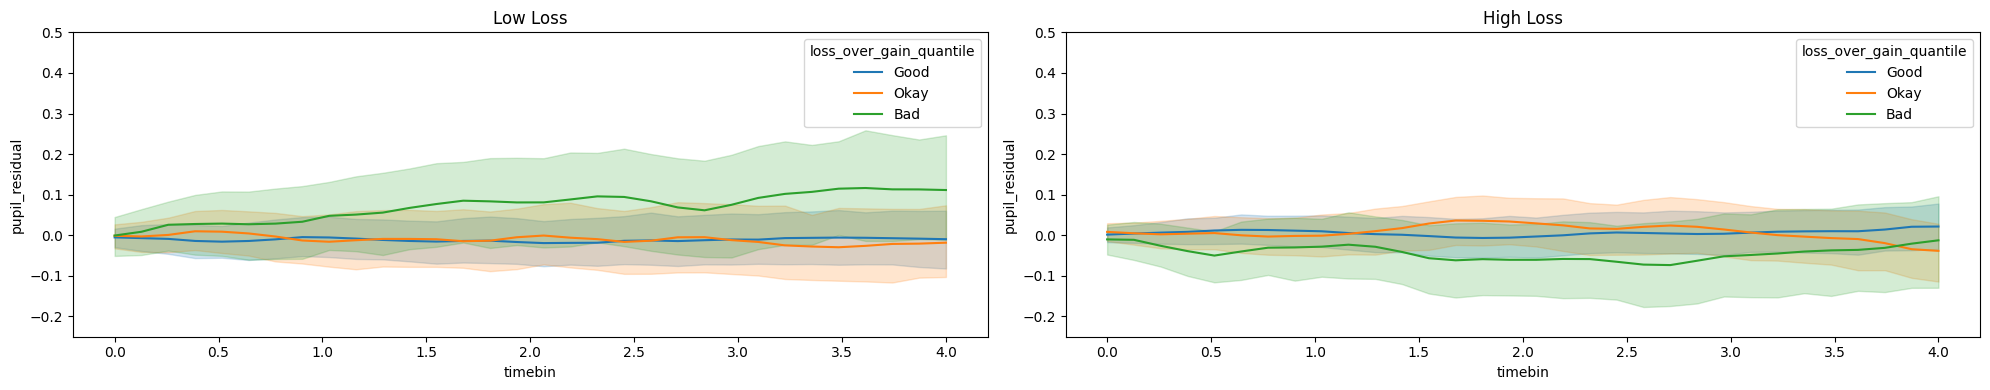

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=True)
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference' & lambda_quantile == 'Low'"), x="timebin", y="pupil_residual", hue="loss_over_gain_quantile", ax=axes[0])
axes[0].set_title("Low Loss")
axes[0].set_ylim(-0.25, 0.5)
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference' & lambda_quantile == 'High'"), x="timebin", y="pupil_residual", hue="loss_over_gain_quantile", ax=axes[1])
axes[1].set_title("High Loss")
axes[1].set_ylim(-0.25, 0.5)
plt.tight_layout()
plt.show()

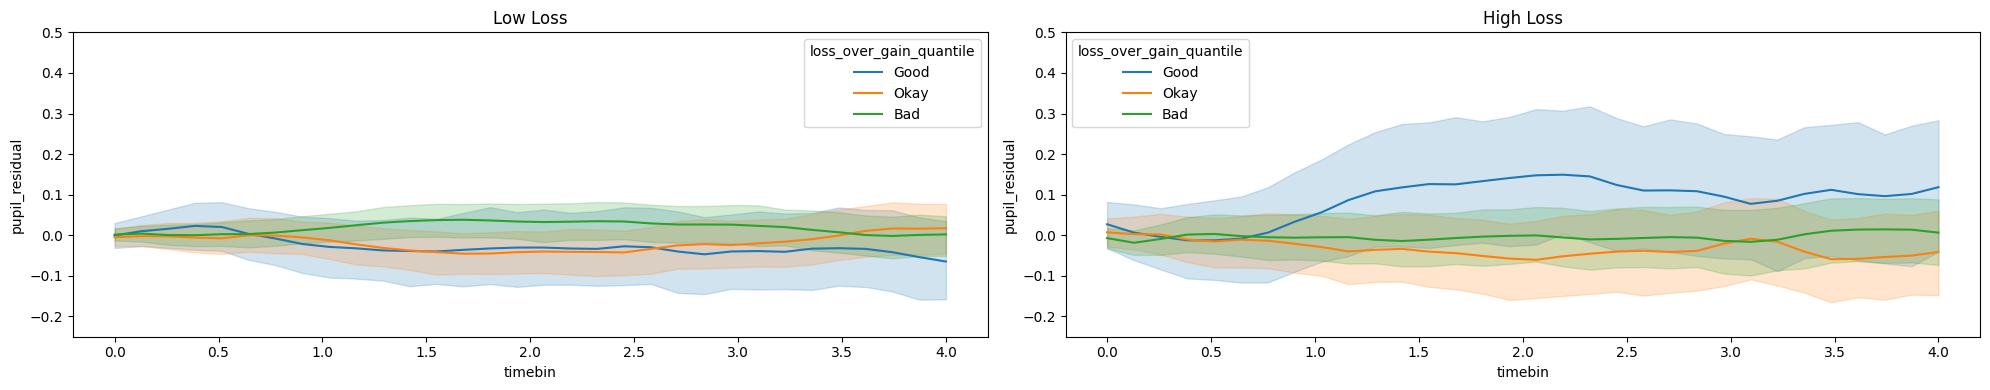

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=True)
sns.lineplot(data=residual_pupil.query("condition == 'equalRange' & lambda_quantile == 'Low'"), x="timebin", y="pupil_residual", hue="loss_over_gain_quantile", ax=axes[0])
axes[0].set_title("Low Loss")
axes[0].set_ylim(-0.25, 0.5)
sns.lineplot(data=residual_pupil.query("condition == 'equalRange' & lambda_quantile == 'High'"), x="timebin", y="pupil_residual", hue="loss_over_gain_quantile", ax=axes[1])
axes[1].set_title("High Loss")
axes[1].set_ylim(-0.25, 0.5)
plt.tight_layout()
plt.show()

What I think is happening here is that the effortful trials are the ones that we are not explaining. We define effort as responding something that is different from your previous things. 

In [36]:
all_subs_effort = []
for sub in behavior["sub"].unique():
    sub_data = behavior.query("sub == @sub")
    response_count = {"accept" : 0, "reject" : 0}
    sub_effort = {"trial" : [], "effort" : [], "sub" : []}
    for trial in sorted(sub_data["trial"].unique()):
        sub_effort["trial"].append(trial)
        sub_effort["sub"].append(sub)

        trial_data = sub_data.query("trial == @trial")
        if trial_data["accept"].values[0] == 1:
            response_count["accept"] += 1
            # I just accepted. If I have been accepting a lot more than rejecting, this is not effortful. 
            if response_count["accept"] > response_count["reject"]:
                sub_effort["effort"].append(0)
            else:
                sub_effort["effort"].append(1)
        else:
            response_count["reject"] += 1
            if response_count["reject"] > response_count["accept"]:
                sub_effort["effort"].append(0)
            else:
                sub_effort["effort"].append(1)
    all_subs_effort.append(pd.DataFrame(sub_effort))
effort = pd.concat(all_subs_effort)

In [46]:
pt_results

,index,Unnamed: 0,sub,condition,param_name,param_value,model,lambda_quantile,effort
0,0,0,1,equalIndifference,lambda,1.019916,model_1,Low,0.137255
1,4,4,2,equalRange,lambda,1.001975,model_1,Low,0.472656
2,8,8,3,equalIndifference,lambda,0.989402,model_1,Low,0.154472
3,12,12,4,equalRange,lambda,0.938581,model_1,Low,0.456349
4,16,16,5,equalIndifference,lambda,1.598506,model_1,High,0.429688
...,...,...,...,...,...,...,...,...,...
103,412,412,119,equalIndifference,lambda,1.102643,model_1,Low,0.160000
104,416,416,120,equalRange,lambda,1.544753,model_1,High,0.248996
105,420,420,121,equalIndifference,lambda,1.303833,model_1,High,0.262745
106,424,424,123,equalIndifference,lambda,1.113116,model_1,Low,0.235294


<Axes: xlabel='param_value', ylabel='effort'>

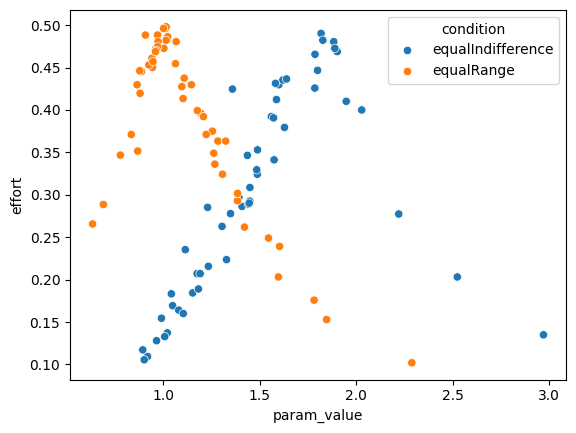

In [37]:
residual_pupil = residual_pupil.merge(effort, on=["sub", "trial"])

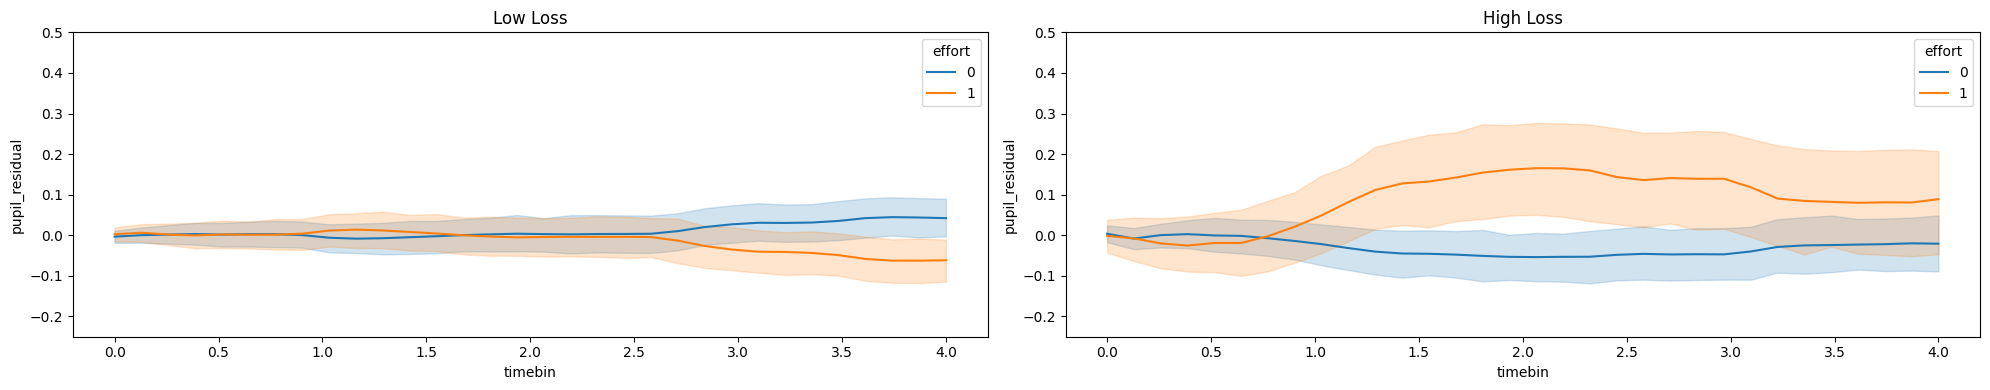

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=True)
sns.lineplot(data=residual_pupil.query("condition == 'equalRange' & lambda_quantile == 'Low'"), x="timebin", y="pupil_residual", hue="effort", ax=axes[0])
axes[0].set_title("Low Loss")
axes[0].set_ylim(-0.25, 0.5)
sns.lineplot(data=residual_pupil.query("condition == 'equalRange' & lambda_quantile == 'High'"), x="timebin", y="pupil_residual", hue="effort", ax=axes[1])
axes[1].set_title("High Loss")
axes[1].set_ylim(-0.25, 0.5)
plt.tight_layout()
plt.show()

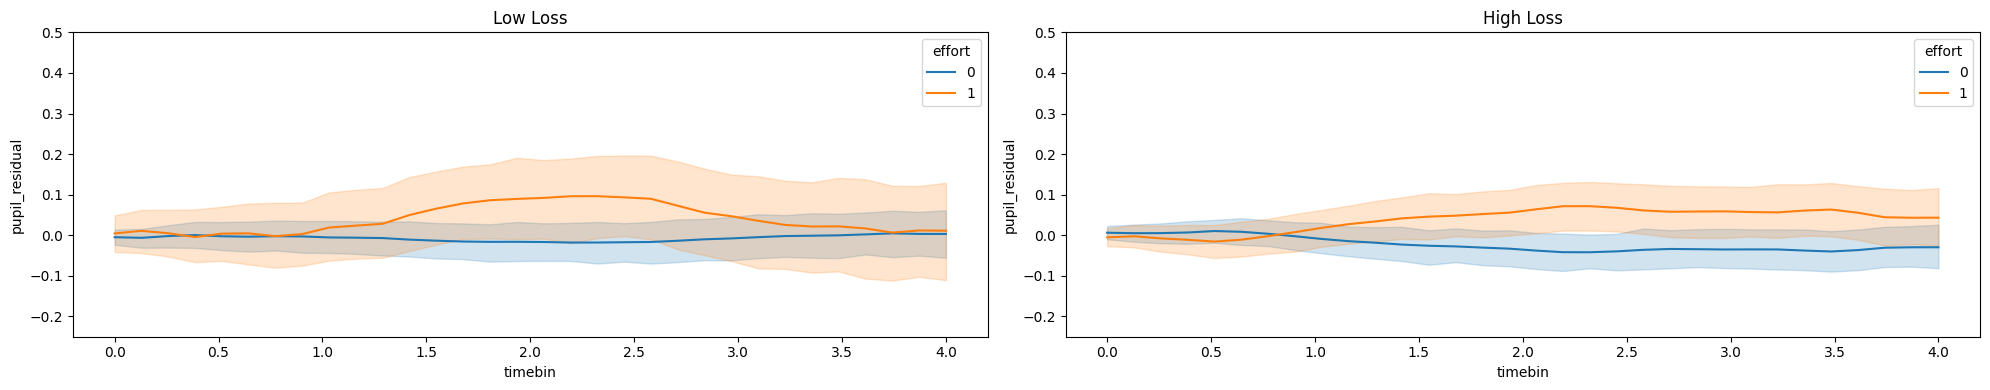

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=True)
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference' & lambda_quantile == 'Low'"), x="timebin", y="pupil_residual", hue="effort", ax=axes[0])
axes[0].set_title("Low Loss")
axes[0].set_ylim(-0.25, 0.5)
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference' & lambda_quantile == 'High'"), x="timebin", y="pupil_residual", hue="effort", ax=axes[1])
axes[1].set_title("High Loss")
axes[1].set_ylim(-0.25, 0.5)
plt.tight_layout()
plt.show()

In [14]:
behavior["loss_over_gain"] = np.log(behavior["loss"] / behavior["gain"])
behavior["uncertain"] = behavior["response_int"].apply(lambda x: 1 if x == 2 or x == 3 else 0)
behavior["loss_over_gain_quantile"] = pd.qcut(behavior["loss_over_gain"], 3, labels=["Good", "Okay", "Bad"])
behavior = behavior.merge(pt_results[["sub", "lambda_quantile"]], on="sub")

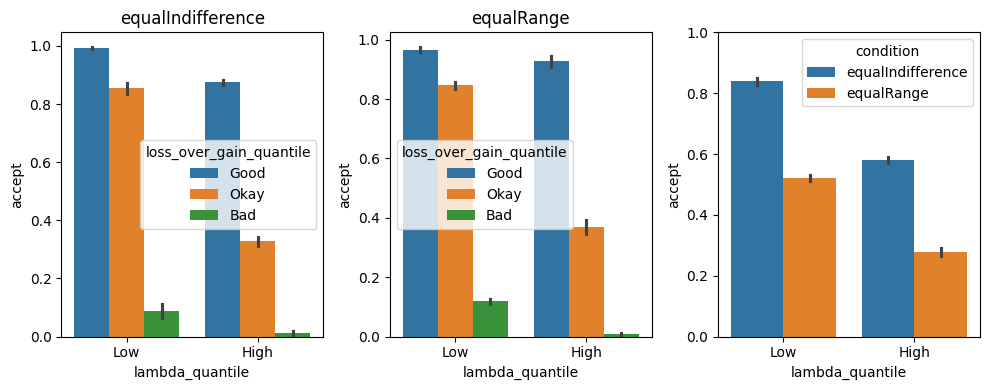

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)
sns.barplot(data=behavior.query("condition == 'equalIndifference'"), x="lambda_quantile", y="accept", hue = "loss_over_gain_quantile", ax=axes[0])
axes[0].set_title("equalIndifference")
sns.barplot(data=behavior.query("condition == 'equalRange'"), x="lambda_quantile", y="accept", hue = "loss_over_gain_quantile", ax=axes[1])
axes[1].set_title("equalRange")
sns.barplot(data=behavior, x="lambda_quantile", y="accept", hue = "condition", ax=axes[2])
axes[2].set_ylim(0, 1)
plt.tight_layout()
plt.show()

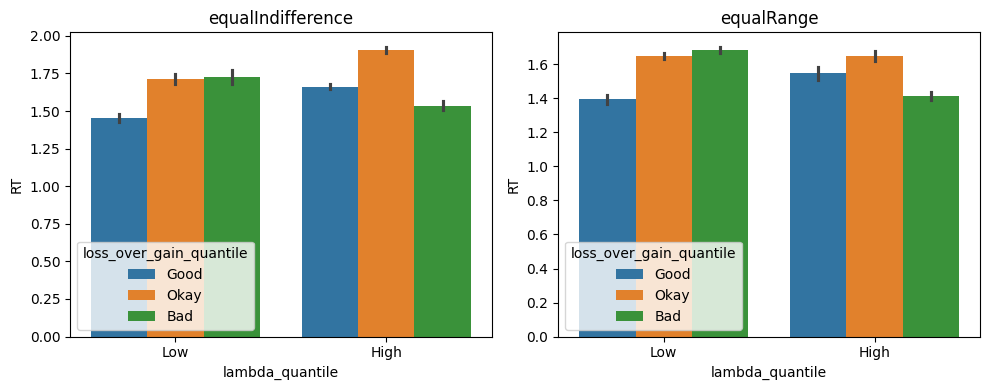

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
sns.barplot(data=behavior.query("condition == 'equalIndifference'"), x="lambda_quantile", y="RT", hue= "loss_over_gain_quantile", ax=axes[0])
axes[0].set_title("equalIndifference")
sns.barplot(data=behavior.query("condition == 'equalRange'"), x="lambda_quantile", y="RT", hue = "loss_over_gain_quantile", ax=axes[1])
axes[1].set_title("equalRange")
plt.tight_layout()
plt.show()

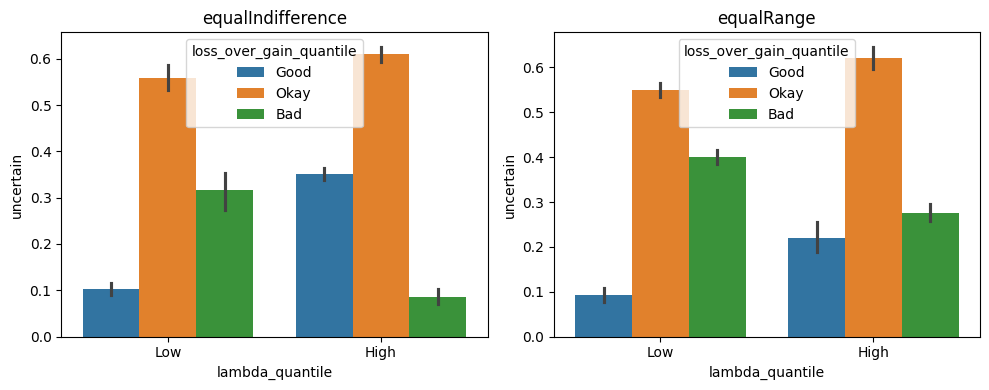

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
sns.barplot(data=behavior.query("condition == 'equalIndifference'"), x="lambda_quantile", y="uncertain", hue= "loss_over_gain_quantile", ax=axes[0])
axes[0].set_title("equalIndifference")
sns.barplot(data=behavior.query("condition == 'equalRange'"), x="lambda_quantile", y="uncertain", hue = "loss_over_gain_quantile", ax=axes[1])
axes[1].set_title("equalRange")
plt.tight_layout()
plt.show()

Visualize the mean pupil dilation time course across condition. 

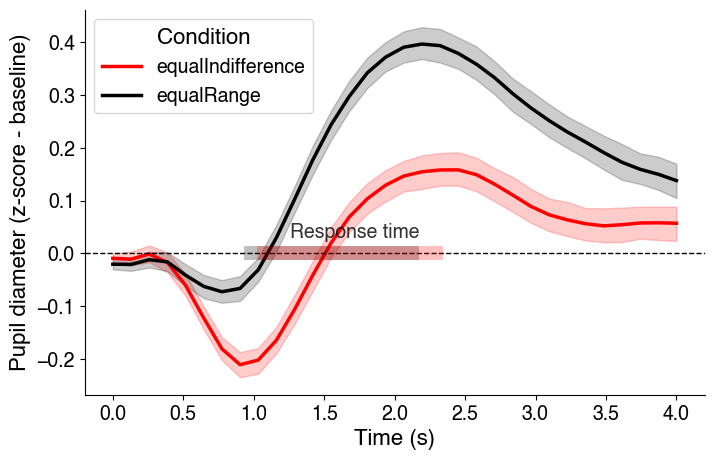

In [38]:
# Create figure
custom_palette = {"equalIndifference": "red", "equalRange": "black"}
fig, ax = plt.subplots(figsize=(8, 5))
# Set the font type
plt.rcParams["font.family"] = "Helvetica"

# Create the line plot with the custom colors
sns.lineplot(data=data, 
             x="timebin", 
             y="pupil_size", 
             hue="condition", 
             palette=custom_palette, 
             linewidth = 2.5)
# Add dashed horizontal line at 0
plt.axhline(0, color="black", linestyle="--", linewidth=1)
# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Set x and y axis labels
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Pupil diameter (z-score - baseline)", fontsize=16)
# Set legend
plt.legend(title="Condition", fontsize=14, title_fontsize=16)
# Make ticks larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Create a thick horizontal line, alpha = 0.5 with black color centered at 1.55 w std = 0.57
plt.plot([1.55 - 0.57, 1.55 + 0.57], [0, 0], color="black", alpha=0.25, linewidth=10)
# Create a thick horizontal line, alpha = 0.5 with red color centered at 1.68 w std = 0.61
plt.plot([1.68 - 0.61, 1.68 + 0.61], [0, 0], color="red", alpha=0.25, linewidth=10)
# Add text to the plot
plt.text(1.72, 0.03, "Response time", fontsize=14, color="black", ha="center", alpha = 0.8)
plt.show()

Visualize the baseline

In [44]:
baseline_mean = data.groupby(["sub", "condition"])["baseline"].mean().reset_index()

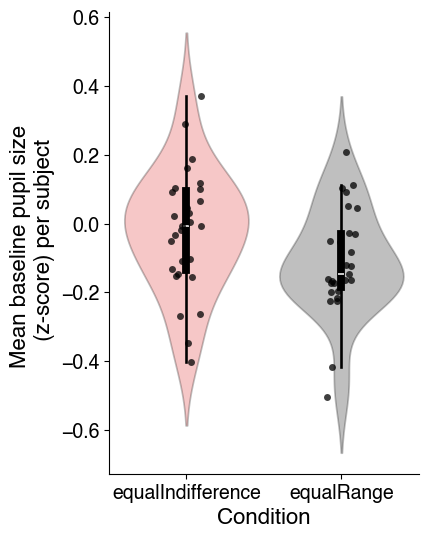

In [54]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.violinplot(data=baseline_mean, x="condition", y="baseline", hue = "condition",  palette=custom_palette, alpha = 0.25)
sns.stripplot(data=baseline_mean, x="condition", y="baseline", color="black", alpha=0.75)
plt.xlabel("Condition", fontsize=16)
plt.ylabel("Mean baseline pupil size \n (z-score) per subject", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()